# OVERVIEW

This notebook pre-trains `xgboost` models on source data. 

The pre-trained models are trained on different random subsets of feature. Full sample is used for pre-training.

The model artifcats are exported to `models/` as `xgb_pretrained1_i.xgb`. The performance dynamics is saved to `results/`.

# PARAMETERS

In [1]:
##### CONFIGURATION

class CFG:
    
    # general
    seed  = 23
    cores = 8
    
    # data
    num_folds = 5
    use_fold  = 0
    drop_cor  = False
    
    # features
    feature_sets = 100
    
    # classifier params
    num_rounds       = 10000
    stop_rounds      = 100
    eta              = 5e-3
    max_depth        = 6
    min_child_weight = 1
    feature_fraction = 0.8
    bagging_fraction = 0.8
    lambda_l1        = 0.01
    lambda_l2        = 0.01
    
    # paths
    data_path  = '../../data/'
    func_path  = '../../codes/'
    model_path = '../../models/'
    out_path   = '../../output/'
    res_path   = '../../results/'

In [2]:
##### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
##### PACKAGES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline                        
import seaborn as sns

import os
import sys
import time
import datetime
import random
import multiprocessing
import pickle
from tqdm import tqdm

import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb

import gc
gc.enable()

import warnings

/Users/kozodoi/opt/anaconda3/envs/tl/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
##### HELPER FUNCTIONS

sys.path.append(CFG['func_path'])
from seed_everything import seed_everything

In [5]:
##### SETTINGS

warnings.filterwarnings('ignore')          # suppress warnings
pd.set_option('display.max_columns', 100)  # max displayed columns 
plt.style.use('dark_background')           # dark plot backround
seed_everything(CFG['seed'])               # randomness

- setting random seed to 23...


# DATA PREP

In [6]:
##### DATA IMPORT

df = pd.read_csv(CFG['data_path'] + 'df_k24.csv')
print(df.shape)
display(df.head())

(133542, 1647)


,uuid,clientdata.loan.amountapplied,clientdata.loan.amountapplied_round,clientdata.loan.amountapplied_roundratio,clientdata.loan.amountapplied_rounddiff,clientdata.loan.installmentsapplied_round,clientdata.loan.amountapplied_statedincome_ratio,clientdata.demo.gender,clientdata.demo.age_year,clientdata.demo.age_month,clientdata.demo.children,clientdata.demo.children_singleparent,clientdata.financial.statedincome,clientdata.email.n_char,clientdata.email.n_numeric,clientdata.email.n_alphabetic,clientdata.email.sim_gmail.com,clientdata.email.sim_hotmail.com,clientdata.email.sim_hotmail.es,clientdata.email.sim_yahoo.es,clientdata.email.sim_yahoo.com,clientdata.email.sim_icloud.com,clientdata.email.sim_outlook.es,clientdata.email.sim_outlook.com,clientdata.createdat.date_sine,clientdata.createdat.date_cos,clientdata.createdat.week_day_sine,clientdata.createdat.week_day_cos,clientdata.createdat.hour_sine,clientdata.createdat.hour_cos,clientdata.mixed.person_athome,clientdata.mixed.income_perperson,clientdata.mixed.amountapplied_perperson,fingerprint.screen_resolution_width,fingerprint.screen_resolution_height,fingerprint.available_width,fingerprint.available_height,fingerprint.horizontal_orientation,fingerprint.maximized_width,fingerprint.maximized_height,fingerprint.color_depth,esEquifax.delinquentDays,esEquifax.numberOfConsumerCreditOperations,esEquifax.numberOfCreditCardOperations,esEquifax.numberOfCreditors,esEquifax.numberOfDaysOfWorstSituation,esEquifax.numberOfMortgageOperations,esEquifax.numberOfPersonalLoanOperations,esEquifax.numberOfTelcoOperations,esEquifax.present,...,esEquifax.RISK_rating_expand_5,esEquifax.RISK_rating_expand_newvalue,esEquifax.SEVERITY_scoringCategory_expand_NA,esEquifax.SEVERITY_scoringCategory_expand_C,esEquifax.SEVERITY_scoringCategory_expand_A,esEquifax.SEVERITY_scoringCategory_expand_D,esEquifax.SEVERITY_scoringCategory_expand_B,esEquifax.SEVERITY_scoringCategory_expand_E,esEquifax.SEVERITY_scoringCategory_expand_newvalue,esEquifax.worstSituationCode_expand_NA,esEquifax.worstSituationCode_expand_1,esEquifax.worstSituationCode_expand_4,esEquifax.worstSituationCode_expand_2,esEquifax.worstSituationCode_expand_3,esEquifax.worstSituationCode_expand_newvalue,kontoconnect.bankfeatures.rule_expand_Caixa_es,kontoconnect.bankfeatures.rule_expand_Bbva_es,kontoconnect.bankfeatures.rule_expand_Bankia_es,kontoconnect.bankfeatures.rule_expand_Santander_es,kontoconnect.bankfeatures.rule_expand_Ing_es,kontoconnect.bankfeatures.rule_expand_Sabadell_es,kontoconnect.bankfeatures.rule_expand_Abanca_es,kontoconnect.bankfeatures.rule_expand_Rural_es,kontoconnect.bankfeatures.rule_expand_Cajamar_es,kontoconnect.bankfeatures.rule_expand_Ibercaja_es,kontoconnect.bankfeatures.rule_expand_Unicaja_es,kontoconnect.bankfeatures.rule_expand_Popular_es,kontoconnect.bankfeatures.rule_expand_Bmn_es,kontoconnect.bankfeatures.rule_expand_Bankinter_es,kontoconnect.bankfeatures.rule_expand_SabadellEmpresas_es,kontoconnect.bankfeatures.rule_expand_newvalue,clientdata.demo.maritalstatus_woe,clientdata.employment.employment_status_woe,clientdata.employment.employment_sector_woe,clientdata.education.degree_woe,clientdata.email.domain_woe,fingerprint.language_woe,fingerprint.language_base_woe,useragent.agent_family_woe,useragent.agent_company_woe,useragent.agent_icon_woe,useragent.os_name_woe,useragent.os_family_woe,useragent.os_company_woe,esEquifax.MICROSCORE_rating_woe,esEquifax.RISK_rating_woe,esEquifax.SEVERITY_scoringCategory_woe,esEquifax.worstSituationCode_woe,kontoconnect.bankfeatures.rule_woe,BAD
0,00jclb,50.0,50,1.0,0.0,1.0,0.031250,1,39,463,1.0,1.0,160000.0,15,0,23,0.400000,0.727273,1.000000,0.300000,0.000000,0.000000,0.400000,0.181818,9.680771e-01,-0.250653,-0.433884,-0.900969,-5.000000e-01,-0.866025,2.0,80000.000000,25.000000,320.0,480.0,320.0,460.0,1.0,1,0.0,32.0,326.395639,0.055723,0.113121,0.574575,5.505233,0.015953,0.10816,0.232673,0.691773,...,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.527071,0.53676

In [7]:
##### PREPARE DATA

# extract target
y = df['BAD']
y = y.map({'BAD': 1, 'GOOD': 0})

# drop target and id
X = df.drop(['BAD', 'uuid'], axis = 1)
del df

# permute features
features = list(X.columns)
random.shuffle(features)
feature_grid = (np.linspace(start = 10, stop = len(features), num = CFG['feature_sets'])).astype('int')

# print BAD ratio
print(y.value_counts(normalize = True))
print(len(features), 'features')

0    0.63887
1    0.36113
Name: BAD, dtype: float64
1645 features


In [8]:
##### DROP CORRELATED FEATURES

if CFG['drop_cor']:

    # timer
    cor_start = time.time()

    # compute correlations
    corr_matrix_p = X.corr().abs()
    corr_matrix_s = X.rank().corr().abs()
    corr_matrix   = np.maximum(corr_matrix_p, corr_matrix_s)
    lower         = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k = -1).astype(np.bool))

    # remove features
    to_drop  = [column for column in lower.columns if any(lower[column] > CFG['drop_cor'])]
    features = [f for f in X.columns if f not in to_drop]
    print('Before:', X.shape)
    X = X[features]
    print('After: ', X.shape)

    # feedback
    print('Finished in {:.2f} minutes'.format((time.time() - cor_start) / 60))

# MODELING

In [9]:
##### CLASSIFIER PARAMETERS

xgb_params = {
    'booster':          'gbtree',
    'tree_method':      'hist',
    'objective':        'binary:logistic',
    'eval_metric':      'auc',
    'learning_rate':    CFG['eta'],
    'max_depth':        CFG['max_depth'],
    'min_child_weight': CFG['min_child_weight'],
    'subsample':        CFG['bagging_fraction'],
    'colsample_bytree': CFG['feature_fraction'],
    'reg_alpha':        CFG['lambda_l1'],
    'reg_lambda':       CFG['lambda_l2'],
    'nthread' :         CFG['cores'],
    'seed':             CFG['seed'],
}

In [10]:
##### MODELING LOOP

# timer
time_start = time.time()

# partitinonig
skf = StratifiedKFold(n_splits = CFG['num_folds'], random_state = CFG['seed'], shuffle = True)

# loop through training folds
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    
    # skip folds
    if fold != CFG['use_fold']:
        continue
    
    # placeholder
    fold_aucs = []
    
    # loop through feature subsets
    for f in range(len(feature_grid)):    
        
        # timer
        f_start = time.time()
        
        # placeholders
        oof_preds   = np.zeros(len(X))
        importances = pd.DataFrame()

        # extract samples
        X_train, y_train = X.iloc[trn_idx][features[0:feature_grid[f]]], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx][features[0:feature_grid[f]]], y.iloc[val_idx]
        
        # convert to DMatrix
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dvalid = xgb.DMatrix(X_valid, label = y_valid)

        # modeling
        clf = xgb.train(params                = xgb_params,
                        dtrain                = dtrain,
                        evals                 = [(dtrain, 'train'), (dvalid, 'valid')],
                        num_boost_round       = CFG['num_rounds'],
                        early_stopping_rounds = CFG['stop_rounds'],
                        verbose_eval          = 0)
        clf.save_model(CFG['model_path'] + 'xgb_pretrained1_{}_fold{}.xgb'.format(f, fold))

        # prediction
        oof_preds[val_idx] = clf.predict(dvalid, iteration_range = (0, clf.best_iteration))
        fold_aucs.append(roc_auc_score(y_valid, oof_preds[val_idx]))

        # feature importance
        if f == len(feature_grid) - 1:
            fold_importance_df = pd.DataFrame.from_dict(clf.get_score(importance_type = 'gain'), orient = 'index').reset_index()
            fold_importance_df.columns = ['Feature', 'Importance']
            fold_importance_df['Fold'] = fold
            importances                = pd.concat([importances, fold_importance_df], axis = 0)

        # information
        print('- training data size: {} x {} | AUC = {:.6f} | {:.2f} min'.format(X_train.shape[0], 
                                                                                 X_train.shape[1],
                                                                                 fold_aucs[f],
                                                                                 (time.time() - f_start) / 60))
        
        # saving performance
        np.save(CFG['res_path'] + 'aucs_pretrained_feats1_fold{}.npy'.format(fold), np.array(fold_aucs))

# display info
print('')
print('Finished in: {:.2f} minutes'.format((time.time() - time_start) / 60))

- training data size: 106833 x 10 | AUC = 0.594822 | 0.48 min
- training data size: 106833 x 26 | AUC = 0.639739 | 1.45 min
- training data size: 106833 x 43 | AUC = 0.656576 | 1.91 min
- training data size: 106833 x 59 | AUC = 0.667533 | 2.55 min
- training data size: 106833 x 76 | AUC = 0.673147 | 2.99 min
- training data size: 106833 x 92 | AUC = 0.676763 | 2.63 min
- training data size: 106833 x 109 | AUC = 0.687095 | 3.16 min
- training data size: 106833 x 125 | AUC = 0.696097 | 3.54 min
- training data size: 106833 x 142 | AUC = 0.711114 | 3.37 min
- training data size: 106833 x 158 | AUC = 0.715080 | 4.01 min
- training data size: 106833 x 175 | AUC = 0.716088 | 3.79 min
- training data size: 106833 x 191 | AUC = 0.720165 | 4.50 min
- training data size: 106833 x 208 | AUC = 0.720365 | 3.43 min
- training data size: 106833 x 224 | AUC = 0.720622 | 4.25 min
- training data size: 106833 x 241 | AUC = 0.722613 | 5.35 min
- training data size: 106833 x 257 | AUC = 0.723756 | 4.20 mi

# RESULTS

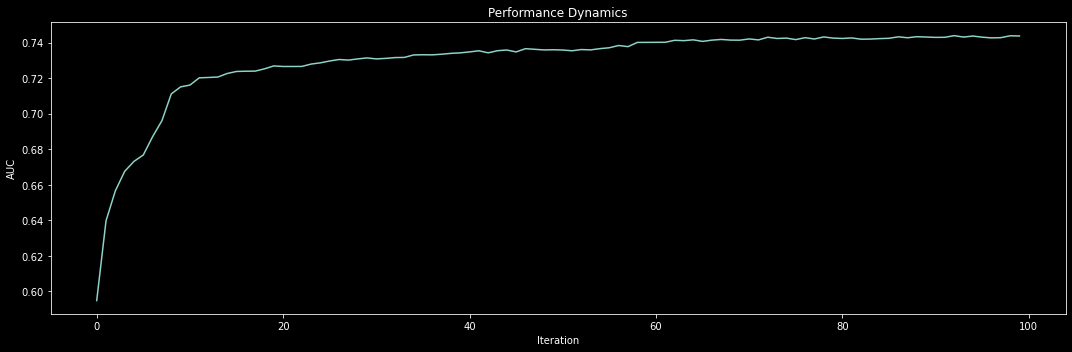

In [11]:
##### PERFORMANCE DYNAMICS

fig = plt.figure(figsize = (15, 5))
sns.lineplot(data = fold_aucs)
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.title('Performance Dynamics')
plt.tight_layout()

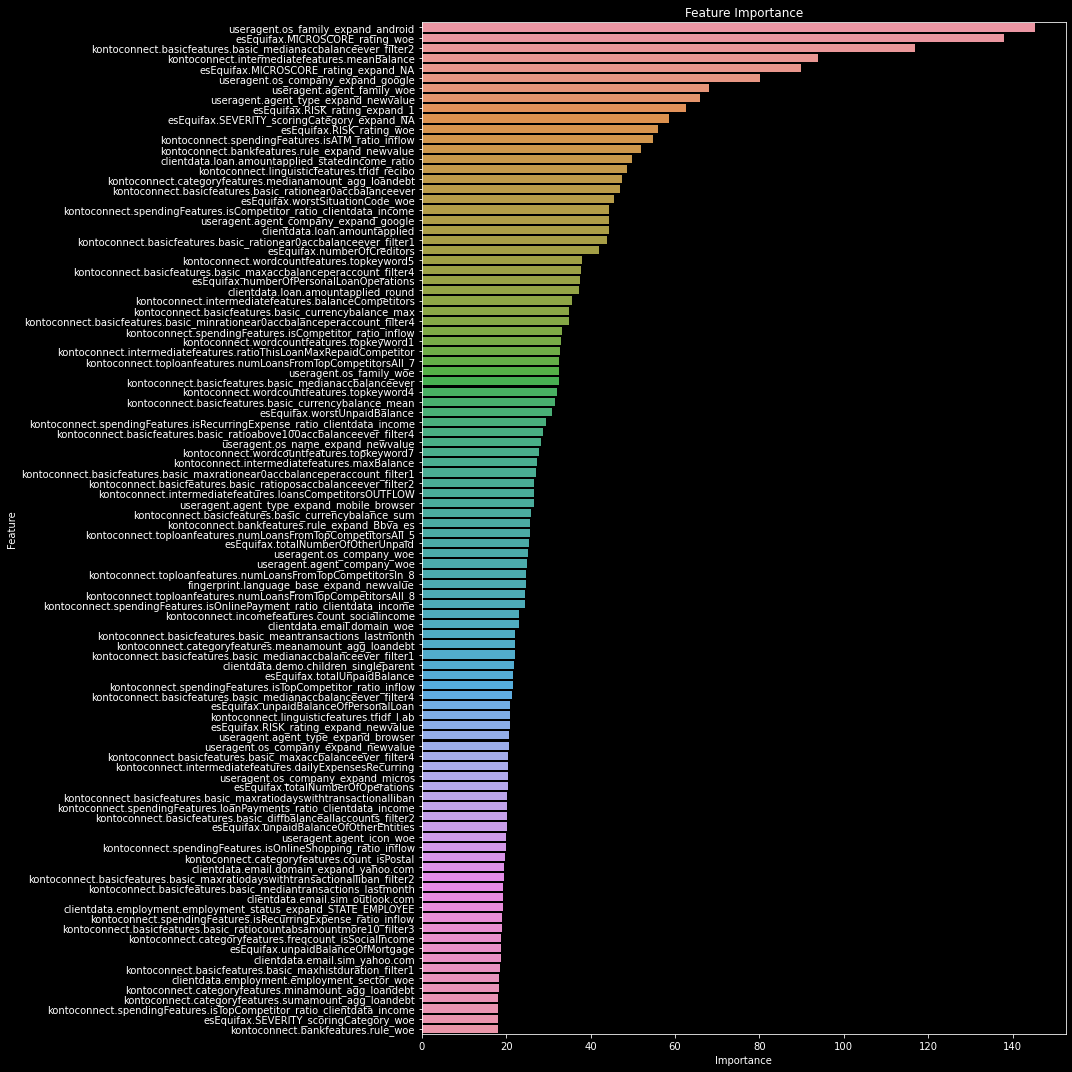

In [12]:
##### FEATURE IMPORTANCE

fig = plt.figure(figsize = (15, 15))
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False).index
importance = importances.loc[importances.Feature.isin(cols)]
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False).head(100), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()